# **Privacy-Preserving Invisible Image Watermarking System**

In [1]:
!pip install -U pip wheel setuptools
!pip install concrete-python

  Using cached concrete_python-2.9.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (12 kB)
  Using cached z3_solver-4.13.0.0-py2.py3-none-manylinux2014_x86_64.whl.metadata (757 bytes)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.

In [1]:
import cv2
from concrete import fhe
import numpy as np
from copy import deepcopy
import time
from matplotlib import pyplot as plt

In [2]:
def read_image(path):
  img = cv2.imread(path)
  return img

In [53]:
cifar_ind = 10
path = f"/content/drive/MyDrive/cifar100/{cifar_ind}.jpg"
img = read_image(path)

In [4]:
l, b, c = img.shape
print(l, b, c)
print(img.shape)

32 32 3
(32, 32, 3)


In [5]:
watermark = b"A watermark for zama bounty"
print(len(watermark))

27


In [6]:
info_bit = 4
mask = 1 << (info_bit-1)
repetition_len = 4
watermark_len = l*b
index = 1

In [7]:
def byte_to_byte_str(bytes):
    return ''.join(format(byte, '08b') for byte in bytes)

def encode_repeated_bits(bits, factor):
    repeated_bits = ''
    for bit in bits:
        repeated_bits += bit*factor
    return repeated_bits

In [8]:
watermark_bits = byte_to_byte_str(watermark)
watermark_bits = encode_repeated_bits(watermark_bits, repetition_len)
# print(watermark_bits)
watermark_bits += '0'*(watermark_len - len(watermark_bits))
print(len(watermark_bits))

1024


In [9]:
x = np.arange(watermark_len)
permutation_map = np.random.permutation(x)

In [10]:
perm_watermark_bits = np.zeros(watermark_len, dtype=int)
inv_permutation_map = np.zeros(watermark_len, dtype=int)

In [11]:
print(len(perm_watermark_bits), len(permutation_map), len(inv_permutation_map))

1024 1024 1024


In [12]:
for i in range(watermark_len):
    # perm_watermark_bits[i] = watermark_bits[i]
    perm_watermark_bits[i] = watermark_bits[permutation_map[i]]
    inv_permutation_map[permutation_map[i]] = i
bool_watermark_bits = [True if perm_watermark_bits[i] else False for i in range(watermark_len)]

In [13]:
def set_bit(bit, val):
  return val | mask if bit else val & (255 - mask)
  # return (val | mask)*bit + (1-bit)*(val & (255 - mask))
def extract_bit(val):
  return (val & mask) == mask

In [14]:
def set_bit_encrypted(bit, val):
  return fhe.multivariate(set_bit)(bit, val)
def extract_bit_encrypted(val):
  return fhe.univariate(extract_bit)(val)

In [50]:
inputset = [(True if np.random.randint(0, 2) else False, np.random.randint(0, 256)) for _ in range(100)]

In [51]:
configuration = fhe.Configuration(p_error=0.01, dataflow_parallelize=True)
encoder_compiler = fhe.Compiler(set_bit_encrypted, {"bit": "encrypted", "val": "encrypted"})
encoder_circuit = encoder_compiler.compile(inputset, configuration=configuration, loop_parallelize=True)

In [52]:
watermarked_img = deepcopy(img)

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      watermarked_img[i][j][index] = encoder_circuit.encrypt_run_decrypt(bool_watermark_bits[i*b+j], img[i][j][index])
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [54]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")
print(f"PSNR after embedding watermark = {cv2.PSNR(watermarked_img, img)}")
watermarked_img_path = f"/content/sample_data/watermarked_image_{cifar_ind}.png"
cv2.imwrite(watermarked_img_path, watermarked_img)

Total time taken = 73.45678718884785 minutes
PSNR after embedding watermark = 33.16546193858141


True

In [41]:
print(watermarked_img[:,:,index])

[[246 247 252 ... 194 247 246]
 [241 245 255 ... 231 245 247]
 [246 244 253 ... 252 255 245]
 ...
 [143  97  83 ... 247 254 246]
 [143  99  96 ... 255 246 254]
 [215 183 220 ... 255 254 246]]


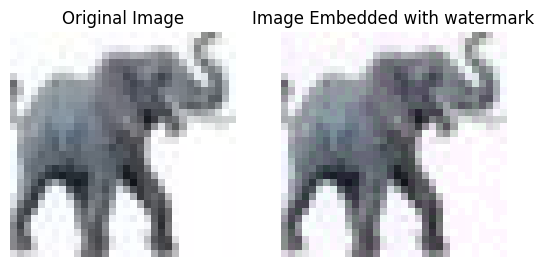

In [42]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(watermarked_img)
plt.axis('off')
plt.title("Image Embedded with watermark")

plt.show()

In [43]:
watermarked_img = read_image(watermarked_img_path)

In [55]:
inputset = [(np.random.randint(0, 256)) for _ in range(100)]

In [56]:
decoder_compiler = fhe.Compiler(extract_bit_encrypted, {"val": "encrypted"})
decoder_circuit = decoder_compiler.compile(inputset, configuration=configuration, loop_parallelize=True)

In [57]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [58]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 19.743716752529146 minutes


In [257]:
def bin_str_to_bytes(bin_str):
    return bytes(int(bin_str[i:i+8], 2) for i in range(0, len(bin_str), 8)).decode('ISO-8859-1')

def decode_repeated_bits(bits, factor):

    def bit_count(bit):
        return sum([1 for i in range(bit.bit_length()) if bit & (1 << i)])

    result_bits = ''
    for i in range(0, len(bits), factor):
        bit_block = bits[i:min(i+factor, len(bits))]
        result_bits += '1' if sum(bit_block) > factor//2 else '0'

    return result_bits

In [42]:
print(mask)

8


In [187]:
decoded_bits = []
for i in range(l):
    # print(f"i : {i}")
    # print(watermarked_img[i, :, index])
    for j in range(b):
      decoded_bits.append(extract_bit(watermarked_img[i][j][index]))

In [59]:
decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
for i in range(watermark_len):
    inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]

In [185]:
def get_decoded_watermark(decoded_bits):
  decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
  inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
  for i in range(watermark_len):
      inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]
  decoded_watermark_bits = decode_repeated_bits(inv_perm_watermark_bits, repetition_len)

  return bin_str_to_bytes(decoded_watermark_bits)

In [46]:
print(''.join([str(i) for i in decoded_bits]))

0011010111011000001101101000100000101111011010000000010000111000001010010100100000000010010011100000001000001011011101010100010000010001110100111000011111110111000100010101101110010011001111000000101001111001000110110000111101011000011010001010000001010011100001000101101000000011110000100010001011000101000001000101000110101101100000110011001010010100010011101000011000000000011000001010011110001100110111010110100011010001110001011011001001111000010111010001101010111010101100000000010001000111100000000100110011101011000010001000001100011001011111011100000011011000000100000111010010100000101100000001011000110110100100100011010110011001011001010000110010010010010101110001001100100100000000010111010100000101010101011000001100000001010111100001110000110110111100010100000001000101000000000110100000101000100010100111001010101100000010110110011100000111000011010101100001000000010001000001011111011110111001000000100110010000100000100100001100110000000100101001001010100000001000100110110100100011

In [47]:
print(''.join([str(i) for i in inv_perm_watermark_bits]))

0000111100000000000000000000111100000000111100000000000000000000000011111111111100001111111111110000111111110000000000000000111100001111111111110000111100000000000011111111000000001111000011110000111111111111000000001111000000001111111100001111111100001111000011111111000000000000000011110000111111111111000000001111000000001111111100001111000011111111000000001111000000000000000000000000111111110000000011111111000000001111111100001111111111111111000011111111111100000000111100000000000011110000000000000000000000001111111111111111000011110000000011111111000000000000000011110000111111110000111111110000111100001111111100000000000000001111000000001111000000000000000000000000111111110000000000001111000000001111111100001111111111111111000011111111111100001111000011110000111111110000111111111111000000001111111111110000111100000000000011111111111111110000000011110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [34]:
print(''.join([str(i) for i in perm_watermark_bits]))

0011010111011000001101101000100000101111011010000000010000111000001010010100100000000010010011100000001000001011011101010100010000010001110100111000011111110111000100010101101110010011001111000000101001111001000110110000111101011000011010001010000001010011100001000101101000000011110000100010001011000101000001000101000110101101100000110011001010010100010011101000011000000000011000001010011110001100110111010110100011010001110001011011001001111000010111010001101010111010101100000000010001000111100000000100110011101011000010001000001100011001011111011100000011011000000100000111010010100000101100000001011000110110100100100011010110011001011001010000110010010010010101110001001100100100000000010111010100000101010101011000001100000001010111100001110000110110111100010100000001000101000000000110100000101000100010100111001010101100000010110110011100000111000011010101100001000000010001000001011111011110111001000000100110010000100000100100001100110000000100101001001010100000001000100110110100100011

In [35]:
print(''.join([str(i) for i in watermark_bits]))

0000111100000000000000000000111100000000111100000000000000000000000011111111111100001111111111110000111111110000000000000000111100001111111111110000111100000000000011111111000000001111000011110000111111111111000000001111000000001111111100001111111100001111000011111111000000000000000011110000111111111111000000001111000000001111111100001111000011111111000000001111000000000000000000000000111111110000000011111111000000001111111100001111111111111111000011111111111100000000111100000000000011110000000000000000000000001111111111111111000011110000000011111111000000000000000011110000111111110000111111110000111100001111111100000000000000001111000000001111000000000000000000000000111111110000000000001111000000001111111100001111111111111111000011111111111100001111000011110000111111110000111111111111000000001111111111110000111100000000000011111111111111110000000011110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [60]:
decoded_watermark_bits = decode_repeated_bits(inv_perm_watermark_bits, repetition_len)
decoded_watermark = bin_str_to_bytes(decoded_watermark_bits)

In [188]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama bounty     


## Performance on distortions/attacks on watermarked image

### JPEG Compression

In [89]:
def compress_image(img, quality=90):

    # Encode the image with JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded_img = cv2.imencode('.jpg', img, encode_param)

    # Decode the compressed image
    decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

    return decoded_img

In [90]:
watermarked_img = read_image(watermarked_img_path)
compressed_img = compress_image(watermarked_img, quality=90)
print(f"PSNR after compression = {cv2.PSNR(compressed_img, watermarked_img)}")

PSNR after compression = 33.42999639495253


In [91]:
decoded_bits = []
for i in range(l):
    # print(f"i : {i}")
    for j in range(b):
      decoded_bits.append(extract_bit(compressed_img[i][j][index]))

In [94]:
decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
for i in range(watermark_len):
    inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]

decoded_watermark_bits = decode_repeated_bits(inv_perm_watermark_bits, repetition_len)
decoded_watermark = bin_str_to_bytes(decoded_watermark_bits)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf4 in position 2: invalid continuation byte

In [93]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama bounty     


### Noise

In [178]:
def add_gaussian_noise(image, mean=0, std=1):
    noise = np.abs(np.random.normal(mean, std, image.shape)).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image, noise

In [263]:
watermarked_img = read_image(watermarked_img_path)
noisy_watermarked_img, noise = add_gaussian_noise(watermarked_img)
print(f"PSNR after adding noise = {cv2.PSNR(noisy_watermarked_img, img)}")

PSNR after adding noise = 33.200027964119116


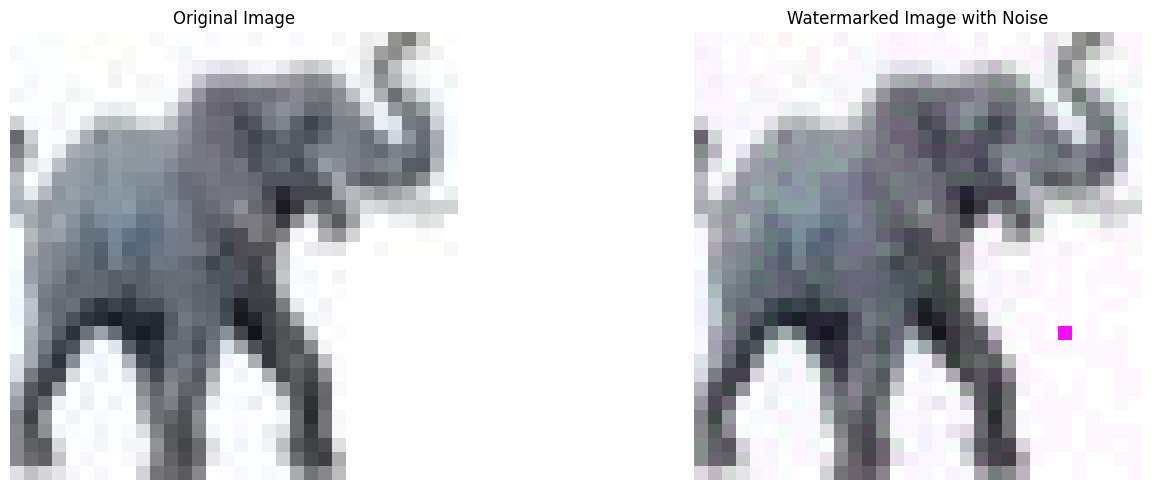

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# axes[1].imshow(noise)
# axes[1].set_title("Gaussian Noise")
# axes[1].axis('off')

axes[1].imshow(noisy_watermarked_img)
axes[1].set_title("Watermarked Image with Noise")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [ ]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1


In [193]:
decoded_bits = []
for i in range(l):
    # print(f"i : {i}")
    for j in range(b):
      decoded_bits.append(extract_bit(noisy_watermarked_img[i][j][index]))

In [194]:
decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
for i in range(watermark_len):
    inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]
decoded_watermark_bits = decode_repeated_bits(inv_perm_watermark_bits, repetition_len)
decoded_watermark = bin_str_to_bytes(decoded_watermark_bits)

In [195]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama b/unty     


### Brightness

In [253]:
watermarked_img = read_image(watermarked_img_path)
brightness = 1.5
contrast = 1.0
weighted_watermarked_img = cv2.addWeighted(watermarked_img, contrast, np.zeros(watermarked_img.shape, watermarked_img.dtype), 0, brightness)
print(f"PSNR after adding noise = {cv2.PSNR(weighted_watermarked_img, img)}")

PSNR after adding noise = 33.234047173253636


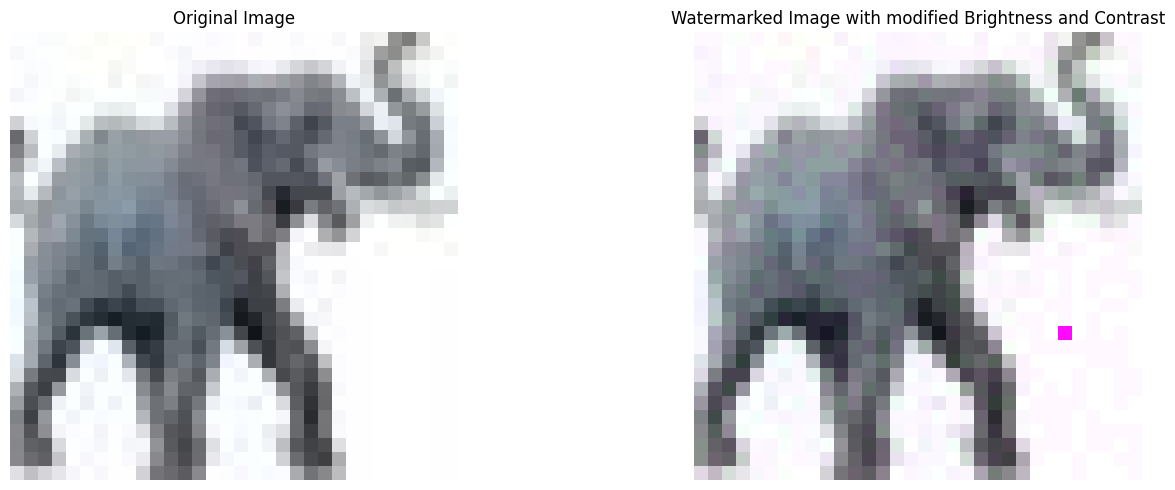

In [254]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# axes[1].imshow(noise)
# axes[1].set_title("Gaussian Noise")
# axes[1].axis('off')

axes[1].imshow(weighted_watermarked_img)
axes[1].set_title("Watermarked Image with modified Brightness and Contrast")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [255]:
decoded_bits = []
for i in range(l):
    # print(f"i : {i}")
    for j in range(b):
      decoded_bits.append(extract_bit(weighted_watermarked_img[i][j][index]))

In [258]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = R${`vmz¡ár}¬ãov{áåa`r/wnôy 0


### Gaussian Blur

In [259]:
watermarked_img = read_image(watermarked_img_path)
blur_watermarked_img = cv2.GaussianBlur(watermarked_img, (1, 1), 0)
print(f"PSNR after gaussian blur = {cv2.PSNR(blur_watermarked_img, img)}")

PSNR after gaussian blur = 33.16546193858141


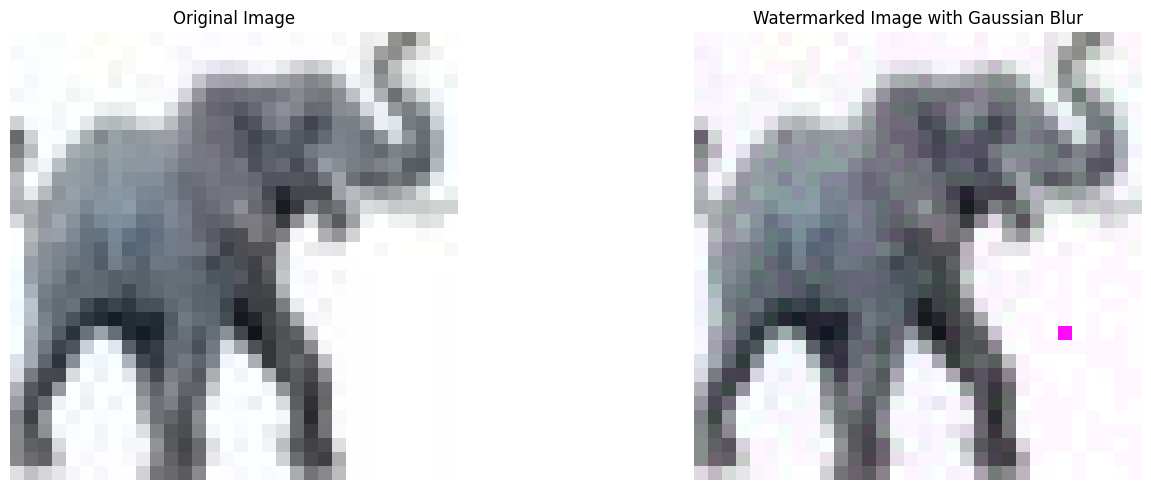

In [260]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# axes[1].imshow(noise)
# axes[1].set_title("Gaussian Noise")
# axes[1].axis('off')

axes[1].imshow(blur_watermarked_img)
axes[1].set_title("Watermarked Image with Gaussian Blur")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [261]:
decoded_bits = []
for i in range(l):
    # print(f"i : {i}")
    for j in range(b):
      decoded_bits.append(extract_bit(blur_watermarked_img[i][j][index]))

In [262]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama bounty     


### Overlay

In [114]:
x = np.array([1,2,3,4])
y = np.array([True, False, True, True])

In [117]:
set_bit(y, x)

array([ 9,  2, 11, 12])